<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/6a_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de máquinas de vectores de soporte mediante descenso por sub-gradiente
En esta libreta veremos cómo entrenar una máquina de vectores de soporte lineal usando el algoritmo PEGASOS (_Primal Estimated sub-GrAdient SOlver for SVM_)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

Definimos nuestra función de pérdida bisagra y la métrica de exactitud

In [ ]:
def exactitud(y, y_predicha):
  return (y == y_predicha).mean() * 100

def bisagra(y, y_predicha):
  return np.maximum(0, 1 - y * y_predicha).sum()

El subgradiente es 0 cuando los puntos caen del lado correcto 

In [ ]:
def subgradiente(w, xi, yi):
  if yi * (w.T @ xi) < 1:
    return yi * xi
  else:
    return 0

Definimos la función del algoritmo PEGASOS

In [ ]:
def pegasos(X, y, n_iter = 1000, l = 0.01):
  Xd = np.column_stack((np.ones(X.shape[0]), X))
  n = Xd.shape[0]
  w = np.zeros(Xd.shape[1])

  t = 0
  for i in range(n_iter):
    perm = np.random.permutation(n)
    for j in range(n):
      t += 1
      decay = 1.0 / t
      eta_t = decay  / l
      w = (1 - decay) * w + eta_t * subgradiente(w, Xd[perm[j]],  y[perm[j]])

  return w

Probamos con la clasificación de 2 flores iris en base a su ancho y largo sepal

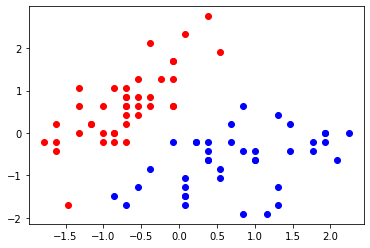

In [ ]:
iris = datasets.load_iris()
    
subconj = np.where(iris['target'] < 2)
X = iris['data'][subconj]
X = X[:, :2]
y = iris['target'][subconj]
y[y == 0] = -1

perm = np.random.permutation(X.shape[0])
X = X[perm,:]
y = y[perm]

X_ent = X[:int(X.shape[0] * 0.8),:]
y_ent = y[:int(X.shape[0] * 0.8)]

sc = StandardScaler()
X_ent = sc.fit_transform(X_ent)

plt.plot(X_ent[y_ent==1, 0], X_ent[y_ent==1, 1], 'bo')
plt.plot(X_ent[y_ent==-1, 0], X_ent[y_ent==-1, 1], 'ro')
plt.show()

Entrenamos nuestro modelo usando el algoritmo PEGASOS

In [ ]:
w = pegasos(X_ent, y_ent, l = 0.001)

Generamos nuestro conjunto de validación y lo reescalamos

In [ ]:
X_val = X[int(X.shape[0] * 0.8):,:]
y_val = y[int(X.shape[0] * 0.8):]
X_val = sc.transform(X_val)
X_val = np.column_stack((np.ones(X_val.shape[0]), X_val))

Predecimos las clases de los datos de validación y evaluamos su exactitud![texto alternativo](https://)

In [ ]:
y_val_predicha = np.sign(X_val @ w.T)
print('Exactitud = {0}%'.format(exactitud(y_val, y_val_predicha)))    

Exactitud = 100.0%


Imprimimos los pesos encontrados

In [ ]:
print('w_1 = {0}, w_2 = {1}, b = {2}'.format(w[1], w[2], w[0]))

w_1 = 4.0086463161686225, w_2 = -2.3891688363262054, b = 0.8250000000000072


Visualizamos el híperplano y los vectores de soporte

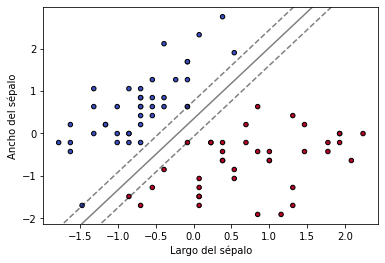

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_ent[:, 0], X_ent[:, 1], c=y_ent, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))

Xr = np.c_[xx.ravel(), yy.ravel()]
Xr = np.column_stack((np.ones(Xr.shape[0]), Xr))

Z = Xr @ w.T
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
ax.set_xlabel('Largo del sépalo')
ax.set_ylabel('Ancho del sépalo')
plt.show()

## Ejercicio
+ Prueba con diferentes valores de $\lambda$.
+ Modifica el código de PEGASOS para realizar la actualización de los parámetros por minilotes y evalúa su convergencia.